# Time on Site Analysis

## Database Connection Stuff

In [115]:
library(RMariaDB)
library(DBI)
library(tidyverse)
library(repr)
library(scales)
library(DataExplorer)
library(lubridate)

source('pw.R')
options(scipen=999)

In [116]:
ds_prod_con <- dbConnect(RMariaDB::MariaDB(), 
                 dbname = "production",
                 host = 'ome-prod-cluster.cluster-ro-cknesi80kqlo.us-west-2.rds.amazonaws.com',
                 username = prod_username,
                 password = prod_password)

ds_billing_con <- dbConnect(RMariaDB::MariaDB(), 
                 dbname = "billing",
                 host = 'billing-api-cluster.cluster-ro-cknesi80kqlo.us-west-2.rds.amazonaws.com',
                 username = billing_username,
                 password = billing_password)

In [117]:
time_on_site_query <- "select user_id, is_remediation, value, created_at, updated_at from user_metrics
where type = 'time'
and user_id not in 
(select users.id
from users
left join role_user ON role_user.`user_id` = users.id
left join roles ON roles.id = role_user.role_id
where roles.id in (1,2,3,4,7,8,9)
or email like '%mailinator.com%'
or email like '%test.com%'
or email like '%+%')"


users_query <- "select cast(u.id as character) as user_id, u.first_name, u.last_name,
s.nickname, s.degree, r.name
from users u
left join schools s
on(u.school_text_id = s.id)
left join role_user ru
on(u.id = ru.user_id)
left join roles r
on(ru.role_id = r.id)
where r.name = 'student' or
r.name = 'professional'"

logins_query <-  "select cast(user_id as character) as user_id, created_at, type
from user_metrics 
where type = 'active_day' and created_at >= '2018-09-27' "

In [118]:
# i'm going to use activity data as a source of truth 
# because it contains the pa_user_created field

time_df <- dbGetQuery(ds_prod_con, time_on_site_query) %>% mutate(user_id = as.character(user_id))
user_df <- dbGetQuery(ds_prod_con, users_query) %>% mutate(user_id = as.character(user_id))
logins_df <- dbGetQuery(ds_prod_con, logins_query) %>% mutate(user_id = as.character(user_id), date = as_date(created_at))

In [119]:
str(logins_df)

'data.frame':	234751 obs. of  4 variables:
 $ user_id   : chr  "202636" "182659" "175390" "119371" ...
 $ created_at: POSIXct, format: "2018-09-26 19:00:15" "2018-09-26 19:00:16" ...
 $ type      : chr  "active_day" "active_day" "active_day" "active_day" ...
 $ date      : Date, format: "2018-09-26" "2018-09-26" ...


In [127]:
dupes_user_metrics <- logins_df %>%
    group_by(user_id, date) %>%
    filter(n() > 1) %>%
    arrange(user_id, date)

In [129]:
head(dupes_user_metrics, 10)

user_id created_at          type       date      
1  100013  2018-10-01 05:46:30 active_day 2018-10-01
2  100013  2018-10-01 20:09:49 active_day 2018-10-01
3  100032  2018-10-06 10:06:10 active_day 2018-10-06
4  100032  2018-10-06 20:20:33 active_day 2018-10-06
5  100387  2018-10-01 05:17:47 active_day 2018-10-01
6  100387  2018-10-01 21:03:05 active_day 2018-10-01
7  100387  2018-10-13 08:45:25 active_day 2018-10-13
8  100387  2018-10-13 21:58:35 active_day 2018-10-13
9  100387  2018-10-17 05:40:41 active_day 2018-10-17
10 100387  2018-10-17 21:38:58 active_day 2018-10-17

In [128]:
str(dupes_user_metrics)

Classes ‘grouped_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	13968 obs. of  4 variables:
 $ user_id   : chr  "100013" "100013" "100032" "100032" ...
 $ created_at: POSIXct, format: "2018-10-01 05:46:30" "2018-10-01 20:09:49" ...
 $ type      : chr  "active_day" "active_day" "active_day" "active_day" ...
 $ date      : Date, format: "2018-10-01" "2018-10-01" ...
 - attr(*, "vars")= chr  "user_id" "date"
 - attr(*, "drop")= logi TRUE
 - attr(*, "indices")=List of 6975
  ..$ : int  0 1
  ..$ : int  2 3
  ..$ : int  4 5
  ..$ : int  6 7
  ..$ : int  8 9
  ..$ : int  10 11
  ..$ : int  12 13
  ..$ : int  14 15
  ..$ : int  16 17
  ..$ : int  18 19
  ..$ : int  20 21
  ..$ : int  22 23
  ..$ : int  24 25
  ..$ : int  26 27
  ..$ : int  28 29
  ..$ : int  30 31
  ..$ : int  32 33
  ..$ : int  34 35
  ..$ : int  36 37
  ..$ : int  38 39
  ..$ : int  40 41
  ..$ : int  42 43
  ..$ : int  44 45
  ..$ : int  46 47
  ..$ : int  48 49
  ..$ : int  50 51
  ..$ : int  52 53
  ..$ : int  54 55
  ..$ : int 

## Let's take a look

Notes: it looks like this field is double-counting some values. When I run sums, I'm getting values that are higher than the amount of time the feature has been available.

In [22]:
head(time_df, 3)

user_id is_remediation value created_at          updated_at         
1 205147  0              34320 2018-09-27 08:03:35 2018-09-27 18:59:34
2 206531  0              17940 2018-09-27 08:03:35 2018-09-27 17:06:45
3 196084  0              44400 2018-09-27 08:03:35 2018-09-27 18:59:36

In [32]:
full <- time_df %>%
    left_join(user_df) %>%
    group_by(user_id, as.Date(created_at), first_name, last_name, 
             nickname, degree, name) %>%
    summarise(mins_on_site = sum(value) / 60) %>%
    rename(date = `as.Date(created_at)`)

head(full, 3)

Joining, by = "user_id"


user_id date       first_name last_name nickname degree name    mins_on_site
1 100013  2018-09-27 Erin       Roberts   JABSOM   MD     student 193         
2 100013  2018-09-28 Erin       Roberts   JABSOM   MD     student 175         
3 100013  2018-09-30 Erin       Roberts   JABSOM   MD     student 103

In [40]:
# over time
daily_stats <- full %>%
    group_by(date) %>%
    summarise(n = n(),
              total_mins_on_site = sum(mins_on_site),
              avg_mins_on_site = mean(mins_on_site)) 

In [46]:
tail(daily_stats, 5)

date       n    total_mins_on_site avg_mins_on_site
1 2018-10-20 2605 373085             143.21881       
2 2018-10-21 2992 433013             144.72360       
3 2018-10-22 3514 409345             116.48976       
4 2018-10-23 3461 414580             119.78619       
5 2018-10-24 1401 119328              85.17345       
  total_mins_on_site_per_user avg_mins_on_site_per_user
1 143.21881                   0.05497843               
2 144.72360                   0.04837019               
3 116.48976                   0.03315019               
4 119.78619                   0.03461028               
5  85.17345                   0.06079475

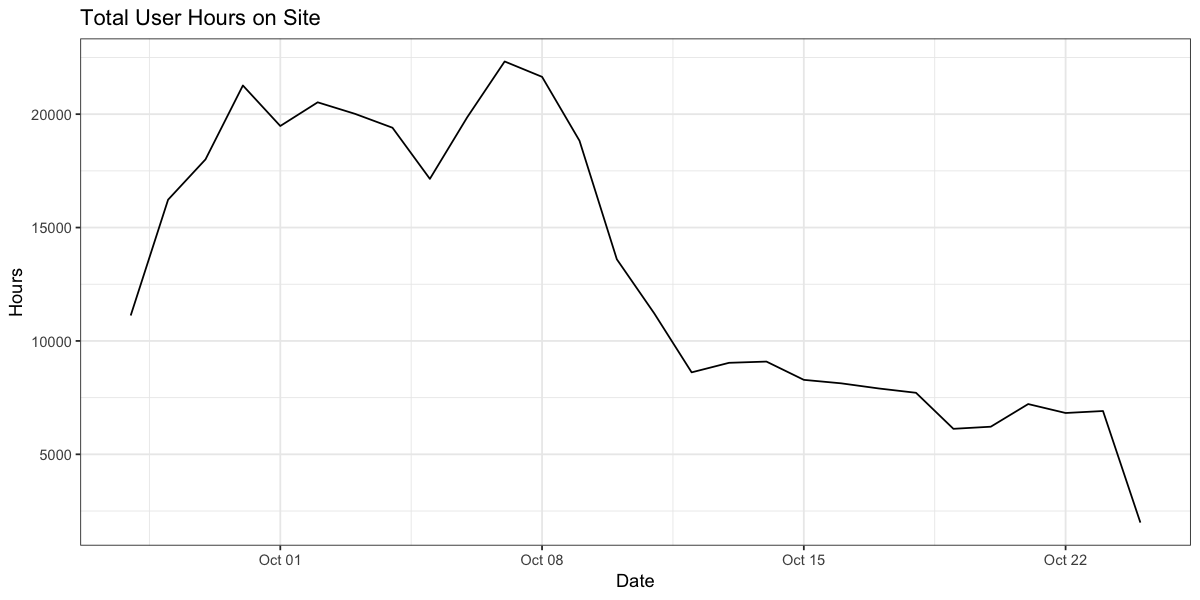

In [67]:
daily_stats %>%
    ggplot(aes(x = date)) + geom_line(aes(y = total_mins_on_site / 60)) +
    theme_bw() + labs(title = "Total User Hours on Site", x = 'Date', y = 'Hours')

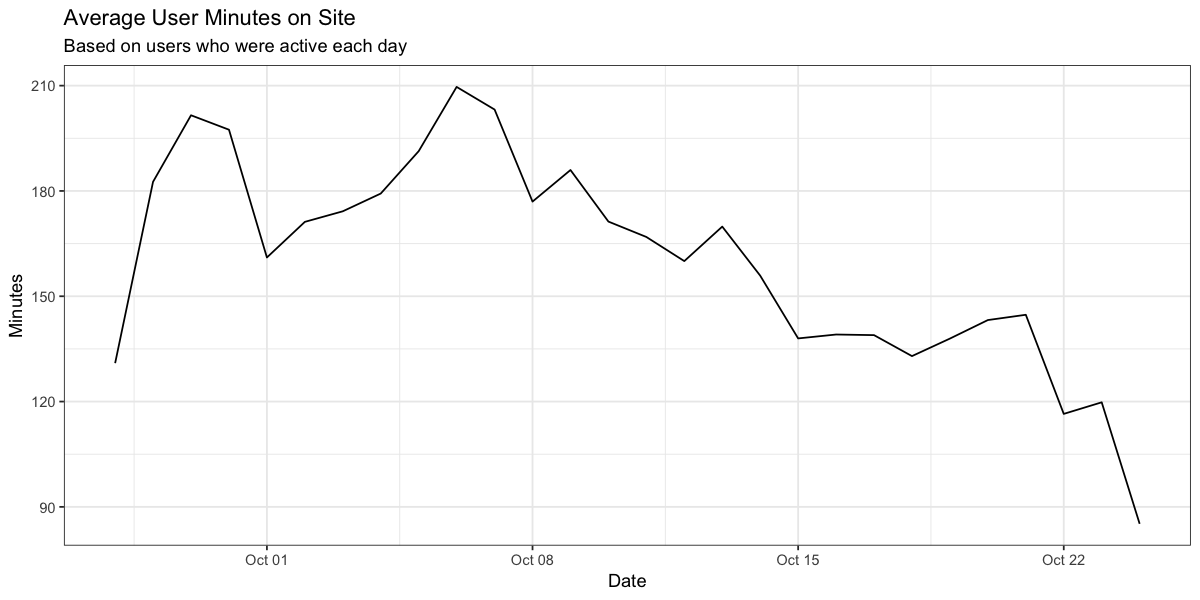

In [64]:
daily_stats %>%
    ggplot(aes(x = date)) + geom_line(aes(y = avg_mins_on_site)) +
    labs(x = "Date", y = "Minutes", title = "Average User Minutes on Site",
              subtitle = "Based on users who were active each day") +
    theme_bw() 

options(repr.plot.width=10, repr.plot.height=5)


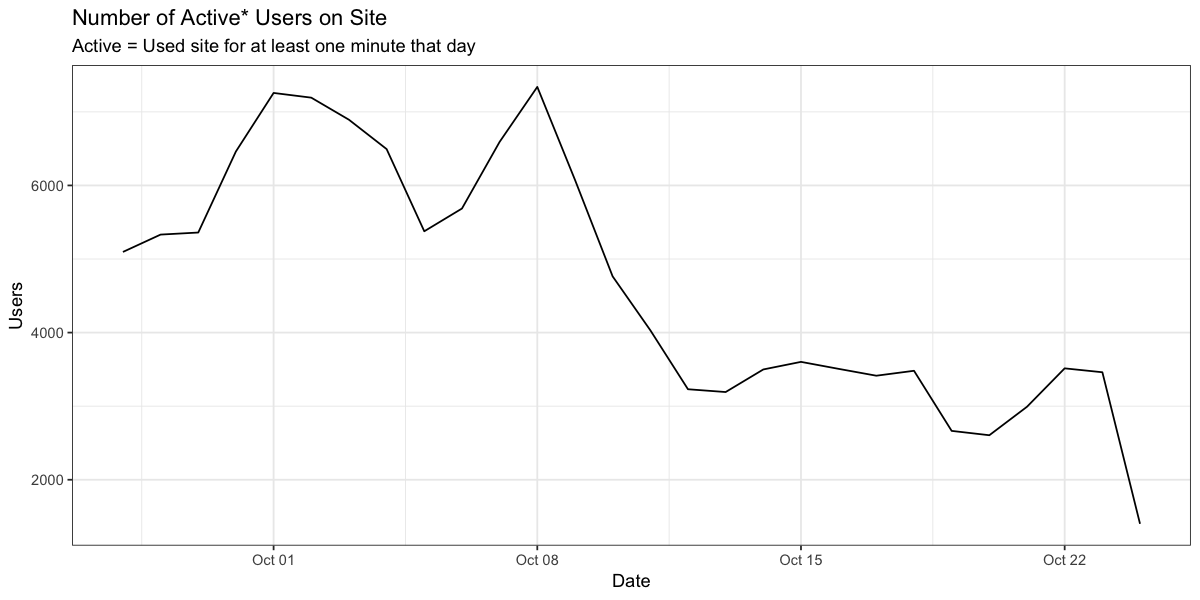

In [70]:
daily_stats %>%
    ggplot(aes(x = date)) + geom_line(aes(y = n)) +
    labs(x = "Date", y = "Users", title = "Number of Active* Users on Site",
              subtitle = "Active = Used site for at least one minute that day") +
    theme_bw() 

In [86]:
# let's compare to the logins data from the user_metrics table
daily_logins <- logins_df %>%
    group_by(as.Date(created_at)) %>%
    summarise(n = n()) %>%
    rename(date = `as.Date(created_at)`) 

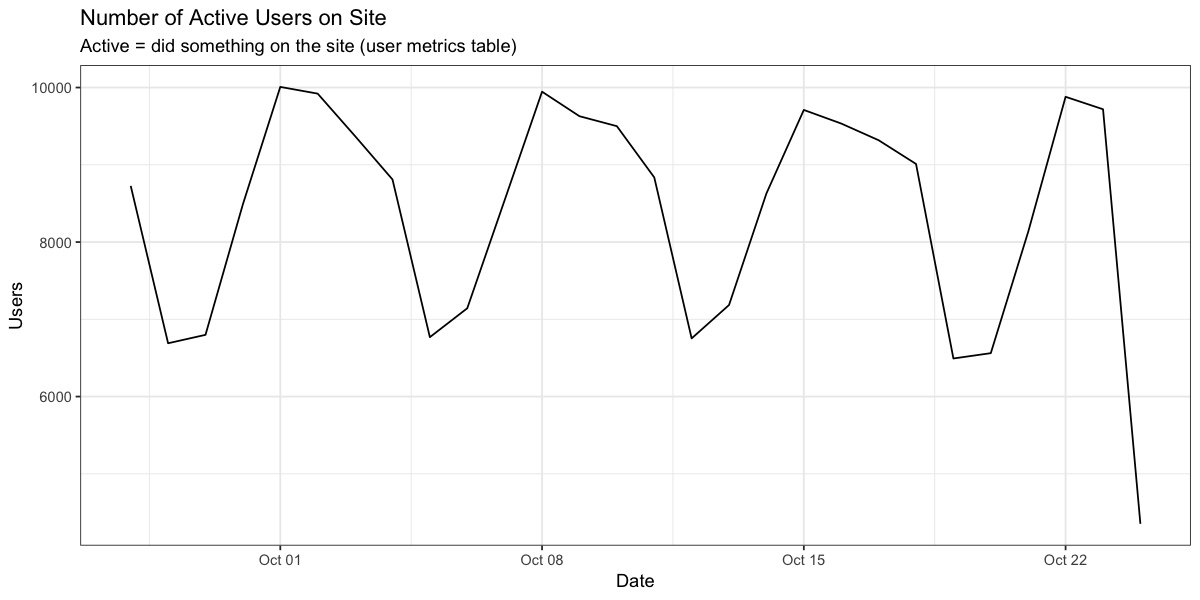

In [89]:
daily_logins %>%
ggplot(aes(x = date, y = n)) + geom_line() +
labs(x = 'Date', y = 'Users', title = 'Number of Active Users on Site',
    subtitle = 'Active = did something on the site (user metrics table)') +
theme_bw()